In this notebook, we plot the basin of attractions for 2D rectified ORGaNICs.

In [ ]:
"""We define the class for simulating the ORGaNICs model."""
import torch
import matplotlib.pyplot as plt
import time
import math
from models.utils.sim_spectrum import sim_solution
import models.ORGaNICs_models as organics
import numpy as np
import os
from matplotlib import colors
from scipy.optimize import fsolve
import warnings


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

### Fixed point for the high dimensional system with W_r = I

In [2]:
"""Define the parameters of the model"""
N = 5
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.001,
    'noise_type': 'additive'
}
b0 = 0.4 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.001 + 0 * torch.abs(torch.randn(N) * 0.001)
Wyy = torch.eye(N)
alpha1 = 1.0
Way = alpha1 * torch.ones(N, N)
# Way = torch.rand(N, N)

# Define the input drive
z = torch.randn(N)
z[0] = 0.0

In [3]:
model = organics.ORGaNICs2DgeneralRectified(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=True)

In [4]:
# Simulation fixed points
y_sim = model.ss[0:N]
a_sim = model.ss[N:2 * N]

In [5]:
# Analystical fixed points
a_analytical = b0 ** 2 * sigma ** 2 + Way @ (torch.relu(b1 * z) ** 2)
y_analytical = -torch.relu(- b1 * z) + torch.relu(b1 * z) / torch.sqrt(a_analytical)

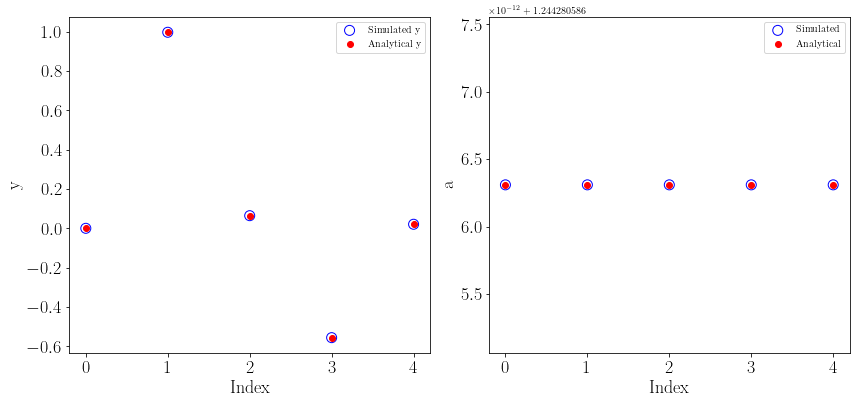

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 columns of subplots

# Plot for y values
ax1.scatter(range(len(y_sim)), y_sim, edgecolors='blue', facecolors='none', label='Simulated y', s=100)
ax1.scatter(range(len(y_analytical)), y_analytical, color='red', label='Analytical y')
ax1.set_xlabel('Index', fontsize=18)
ax1.set_ylabel('y', fontsize=18)
ax1.legend()
ax1.tick_params(axis='both', which='major', labelsize=18)

# Plot for a values
ax2.scatter(range(len(a_sim)), a_sim, edgecolors='blue', facecolors='none', label='Simulated', s=100)
ax2.scatter(range(len(a_analytical)), a_analytical, color='red', label='Analytical')
ax2.set_xlabel('Index', fontsize=18)
ax2.set_ylabel('a', fontsize=18)
ax2.legend()
ax2.tick_params(axis='both', which='major', labelsize=18)

# Adjust overall figure settings
# Remove individual subplot titles and adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()  # Display the plot

In [7]:
# We check the Jacobian matrix we get by simulation vs the analytical jacobian with rectification
J = model.J
J1 = J[0:model.Ny, 0:model.Ny]
J2 = J[0:model.Ny, model.Ny:2*model.Ny]
J3 = J[model.Ny:2*model.Ny, 0:model.Ny]
J4 = J[model.Ny:2*model.Ny, model.Ny:2*model.Ny]

y = model.ss[0:model.Ny]
a = model.ss[model.Ny:2*model.Ny]
W = Way

J1p = - torch.diag((torch.sqrt(a) * torch.heaviside(z, torch.tensor([1.0])) + torch.ones_like(a) * torch.heaviside(-z, torch.tensor([0.0])))/ model.tauY)
J2p = - torch.diag(torch.relu(y) / (2 * torch.sqrt(a) *  model.tauY))
J3p = torch.diag(1 / model.tauA) @ (2 * W @ torch.diag(a * torch.relu(y)))
# J3p = (2 * W @ torch.diag(a * torch.relu(y))) / model.tauA
J4p = torch.diag(1 / model.tauA) @ (- torch.eye(model.Ny) + W @ torch.diag(torch.relu(y)**2))

# chekc if J1p, J2p, J3p, J4p are equal to J1, J2, J3, J4
print('J1p == J1: ', torch.allclose(J1p, J1))
print('J2p == J2: ', torch.allclose(J2p, J2))
print('J3p == J3: ', torch.allclose(J3p, J3))
print('J4p == J4: ', torch.allclose(J4p, J4))

J1p == J1:  True
J2p == J2:  True
J3p == J3:  True
J4p == J4:  True


In [8]:
torch.heaviside(z, torch.tensor([1.0]))

tensor([1., 1., 1., 0., 1.])

In [9]:
# We check the eignevalues against the analytical solution
print(torch.linalg.eigvals(model.J))

num = alpha1 * torch.norm(torch.relu(b1 * z)) ** 2
denm = sigma ** 2 * b0 ** 2 + num

# defining the quadratic equation
coeff_b = (1 / model.tauA) * (1 - num / denm) + torch.sqrt(denm) / model.tauY
coeff_c = torch.sqrt(denm) / (model.tauY * model.tauA)



# purely real roots
print(- 1 / model.tauA)
print(- 1 / model.tauY)
print(- torch.sqrt(denm) / model.tauY)

# potentially complex roots
print(-coeff_b / 2 + 1j * torch.sqrt(torch.abs(coeff_c - coeff_b ** 2 / 4)))
print(-coeff_b / 2 - 1j * torch.sqrt(torch.abs(coeff_c - coeff_b ** 2 / 4)))

tensor([ -500.0000+0.0000j,  -558.0581+496.2941j,  -558.0581-496.2941j,
        -1115.4733+0.0000j,  -500.0000+0.0000j, -1115.4733+0.0000j,
         -500.0000+0.0000j,  -500.0000+0.0000j, -1115.4733+0.0000j,
        -1000.0000+0.0000j])
tensor([-500., -500., -500., -500., -500.])
tensor([-1000., -1000., -1000., -1000., -1000.])
tensor([-1115.4733, -1115.4733, -1115.4733, -1115.4733, -1115.4733])
tensor([-558.0581+496.2941j, -558.0581+496.2941j, -558.0581+496.2941j,
        -558.0581+496.2941j, -558.0581+496.2941j])
tensor([-558.0581-496.2941j, -558.0581-496.2941j, -558.0581-496.2941j,
        -558.0581-496.2941j, -558.0581-496.2941j])


### Analysis of the two-dimensional model

In [132]:
"""Define the parameters of the model"""
N = 1
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.001,
    'noise_type': 'additive'
}
b0 = 0.5 * torch.ones(N)
# b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = 0.1
# sigma = 0.1
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.01 + 0 * torch.abs(torch.randn(N) * 0.001)
Wyy = torch.tensor([[1.0]])
# Wyy = torch.tensor([[0.5]])
Way = torch.tensor([[1.0]])

# Define the input drive
z = torch.tensor([1.0])

In [133]:
"""Define the model"""
model = organics.ORGaNICs2DgeneralRectified(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, run_jacobian=False)

Find the fixed point of the system.

In [134]:
# We define the gradients for a given location
def fixed_point_func(variables):
    y, a = variables
    x = torch.tensor((y, a))
    grad = model._dynamical_fun(0, x)
    return [grad[0], grad[1]]

In [135]:
# We solve the equivalent quartic equation, valid when 0 < w_r < 1
a = Wyy ** 2
b = 2 * (1 - Wyy) * Wyy
c = (1 - Wyy) ** 2 - Way * (b1 * z) ** 2 - b0 ** 2 * sigma ** 2 * Wyy ** 2
d = - 2 * (1 - Wyy) * Wyy * b0 ** 2 * sigma ** 2
e = - (1 - Wyy) ** 2 * b0 ** 2 * sigma ** 2

In [136]:
a_prime = Wyy ** 2
b_prime = - 2 * (1 - Wyy) * Wyy
c_prime = (1 - Wyy) ** 2 - Way * torch.relu(b1 * z) ** 2 - b0 ** 2 * sigma ** 2 * Wyy ** 2
d_prime = 2 * Way * torch.relu(b1 * z) ** 2 * (1 - Wyy) / Wyy
e_prime = - (1 - Wyy) ** 2 * torch.relu(b1 * z) ** 2 * Way / Wyy ** 2

In [137]:
coefficients = [a.item(), b.item(), c.item(), d.item(), e.item()]

print("Coefficients:", coefficients)
sqrt_a_roots = np.roots(coefficients)
print("Roots:", sqrt_a_roots)

Coefficients: [1.0, 0.0, -0.2525, -0.0, -0.0]
Roots: [ 0.50249378 -0.50249378  0.          0.        ]


In [138]:
coefficients_prime = [a_prime.item(), b_prime.item(), c_prime.item(), d_prime.item(), e_prime.item()]
print("Coefficients prime:", coefficients_prime)
roots_prime = np.roots(coefficients_prime)
print("Roots prime:", torch.tensor(roots_prime) + (Wyy - 1) / Wyy)

Coefficients prime: [1.0, -0.0, -0.2525, 0.0, -0.0]
Roots prime: tensor([[ 0.5025, -0.5025,  0.0000,  0.0000]])


In [139]:
fixed_points = []
stability = []
jacobians = []
eigs = []

for root in sqrt_a_roots:
    # check if real and positive
    if abs(np.imag(root)) < 1e-10 and np.real(root) > 0:
        a_s = np.real(root) ** 2
        y_s = (b1 * z / (1 - Wyy + Wyy * np.real(root))).numpy().item()
        fixed_points.append([y_s, a_s])
        # calculate the jacobian at the given fixed point
        J, _ = model.jacobian_autograd(ss=torch.tensor([y_s, a_s]))
        jacobians.append(J)
        eigs.append(torch.linalg.eigvals(J))
        # check real parts of eigenvalues and determine stability
        if torch.all(torch.real(torch.linalg.eigvals(J)) < 0):
            stability.append("stable")
        else:
            stability.append("unstable")

# print the fixed points and stability
print("Fixed points:", fixed_points)
print("Stability:", stability)
print("Eigenvalues:", eigs)

Fixed points: [[0.9950371902099893, 0.25249999999999995]]
Stability: ['stable']
Eigenvalues: [tensor([-27.5999+156.0863j, -27.5999-156.0863j])]


In [140]:
b0 * sigma - (1 - 1 / Wyy)

tensor([[0.0500]])

Find the phase portrait of the system.

In [141]:
# We define the gradients for a given location
def organics_gradient(y, a):
    x = torch.tensor((y, a))
    grad = model._dynamical_fun(0, x)
    return grad[0], grad[1]

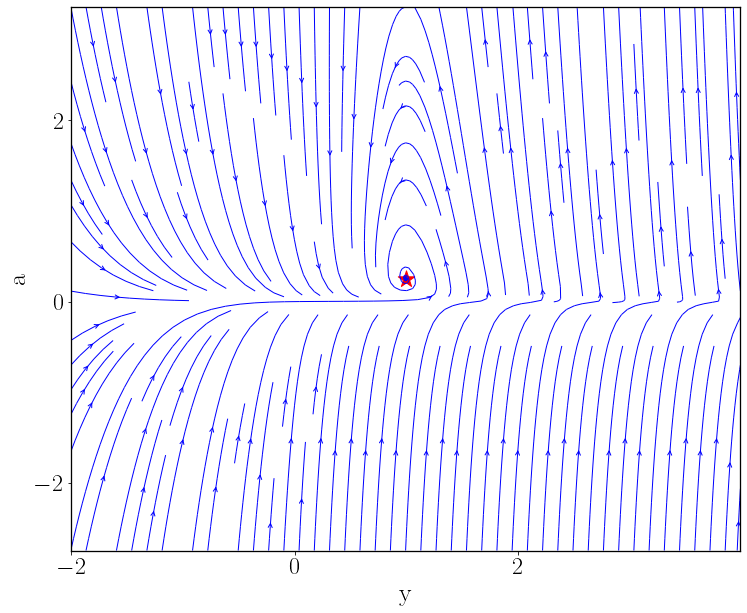

In [ ]:
for idx, fixed_point in enumerate(fixed_points):
    if stability[idx] == "stable":
        if z > 0:
            if fixed_point[0] > 0:
                centre_point = fixed_point
        else:
            centre_point = [(b1 * z).item(), (b0 ** 2 * sigma ** 2).item()]
            

# right = 3
# up = 5
# down = 3
# left = 3

right = 3
up = 3
down = 3
left = 3
points = 200j

a, y = np.mgrid[centre_point[1]-down:centre_point[1]+up:points, centre_point[0]-left:centre_point[0]+right:points]

# run a for loop to get the gradients
u = np.zeros_like(y)
v = np.zeros_like(a)
for i in range(y.shape[0]):
    for j in range(a.shape[1]):
        u[i, j], v[i, j] = organics_gradient(y[i, j], a[i, j])  # Assuming you have a function named organics_gradient

plt.figure(figsize=(12, 10))  # Adjusted figure size

# Create the stream plot
plt.streamplot(y, a, u, v, color='blue', linewidth=1, density=1.5, arrowstyle='->')


for idx, fixed_point in enumerate(fixed_points):
    if z > 0:
        if stability[idx] == "stable":
            if fixed_point[0] > 0:
                plt.scatter(fixed_point[0], fixed_point[1], color='red', marker='*', s=300)
    else:
        plt.scatter(centre_point[0], centre_point[1], color='red', marker='*', s=300)
        if fixed_point[0] > 0:
            if stability[idx] == "stable":
                plt.scatter(fixed_point[0], fixed_point[1], color='red', marker='*', s=300)
            else:
                plt.scatter(fixed_point[0], fixed_point[1], color='black', marker='*', s=300)


# Customizing the plot
plt.xlabel('y', fontsize=26)
plt.ylabel('a', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Make the border thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.3)  # Set the desired thickness here

# Reduce the number of ticks
# Reduce the number of ticks to only show integers
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3, integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(3, integer=True))



# Save the figure
# file_name = 'rectified/taus_equal.svg'
# file_name = 'rectified/taua_0.01_tauy_0.002.svg'
file_name = 'rectified/taua_0.002_tauy_0.01.svg'
# file_name = 'rectified/z_positive_wr_greater_1_b0_sigma_more.svg'
# file_name = 'rectified/z_negative_wr_greater_1_b0_sigma_more.svg'
file_path = '../../figures/' + file_name
plt.savefig(file_path, bbox_inches='tight', format='svg', dpi=500)

# Showing the plot
plt.show()